# dNBR image generation using Landsat
This notebook can be used to generate a delta - Normalised Burn Ratio image (dNBR) image for studing the effect of bushfires.

In [7]:
# Determine what is required and what is not here

import pandas as pd
import geopandas as gpd
import xarray as xr
import sys, os
import time
import multiprocessing
ncpus = multiprocessing.cpu_count()
#from BurnCube import BurnCube #including burn mapping main functions
#bc = BurnCube()

from datacube_stats.statistics import GeoMedian

import datacube
from datacube.storage import masking
from odc.ui import with_ui_cbk
from dea_plotting import display_map
from dea_plotting import rgb
from datacube.helpers import write_geotiff
#import dea_datahandling
#from datacube.storage.storage import write_dataset_to_netcdf
#from datacube.helpers import write_geotiff

dc = datacube.Datacube(app='dc_dNBR')

sys.path.append(os.path.abspath('/g/data/r78/DPIPWE_lm/repos/dea-notebooks/Scripts'))
from dea_bandindices import calculate_indices



#Specify output directory
outputdir = '/g/data/r78/DPIPWE_lm/output_data/'
if not os.path.exists(outputdir):
    print("output directory doesn't exist")
    exit()

In [2]:
# Define two queries for the fire affected area, One pre-fire and one-post fire
lat = (-41.68, -41.87)
long = (145.2, 145.5)


query_pre = {
        'lat': lat,
        'lon': long,
        #'crs': 'EPSG:3577',
        #'output_crs': 'EPSG:3577',
        'time': ('2019-01-20'),
        'resolution': (-30, 30)
        }

query_post = {
        'lat': lat,
        'lon': long,
        #'crs': 'EPSG:3577',
        #'output_crs': 'EPSG:3577',
        'time': ('2019-03-01'),
        'resolution': (-30, 30)
        }

In [3]:
# Use the calculate indices script to calculate NBR for images (could also do band math)
dc_data_pre = dc.load(product='ls8_nbart_albers', measurements=['blue', 'green','red','nir', 'swir2'],
                      group_by = 'solar_day', progress_cbk=with_ui_cbk(), **query_pre)
dc_data_post = dc.load(product='ls8_nbart_albers', measurements=['blue', 'green','red','nir', 'swir2'],
                       group_by = 'solar_day', progress_cbk=with_ui_cbk(), **query_post)

'''
Band math version

dc_data_pre['NBR'] = (dc_data_pre.nir - ds_data_pre.swir2) / (dc_data_pre.nir + ds_data_pre.swir2)
dc_data_post['NBR'] = (dc_data_post.nir - ds_data_post.swir2) / (dc_data_post.nir + ds_data_post.swir2)
'''

"\nBand math version\n\ndc_data_pre['NBR'] = (dc_data_pre.nir - ds_data_pre.swir2) / (dc_data_pre.nir + ds_data_pre.swir2)\ndc_data_post['NBR'] = (dc_data_post.nir - ds_data_post.swir2) / (dc_data_post.nir + ds_data_post.swir2)\n"

In [4]:
# Check dataset
dc_data_pre

<xarray.Dataset>
Dimensions:  (time: 1, x: 919, y: 772)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-20T23:58:17
  * y        (y) float64 -4.615e+06 -4.615e+06 ... -4.638e+06 -4.638e+06
  * x        (x) float64 1.122e+06 1.122e+06 1.122e+06 ... 1.149e+06 1.149e+06
Data variables:
    blue     (time, y, x) int16 165 145 149 150 146 144 ... 61 60 63 79 81 79
    green    (time, y, x) int16 271 263 274 282 262 247 ... 200 223 266 280 256
    red      (time, y, x) int16 189 149 149 156 157 141 ... 107 127 157 159 161
    nir      (time, y, x) int16 2305 2387 2378 2260 2105 ... 2303 2492 2418 2229
    swir2    (time, y, x) int16 296 308 317 315 283 276 ... 241 240 337 349 333
Attributes:
    crs:      EPSG:3577

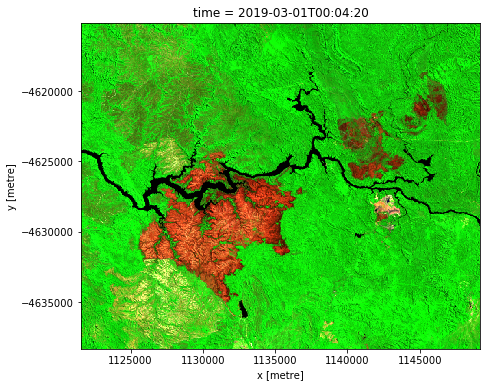

In [10]:
# Plot the results
rgb(ds=dc_data_post.isel(time=0), bands = ['swir2', 'nir', 'green'])

In [11]:
# Combine the two images into one dataset for processing
dc_comb = xr.concat([dc_data_pre, dc_data_post], dim='time')

In [12]:
#Calculate NBR for the two time slices 
dc_NBR = calculate_indices(dc_comb, index='NBR', drop=True, collection='ga_ls_3')
dc_NBR

Dropping bands ['blue', 'green', 'red', 'nir', 'swir2']


<xarray.Dataset>
Dimensions:  (time: 2, x: 919, y: 772)
Coordinates:
  * y        (y) float64 -4.615e+06 -4.615e+06 ... -4.638e+06 -4.638e+06
  * x        (x) float64 1.122e+06 1.122e+06 1.122e+06 ... 1.149e+06 1.149e+06
  * time     (time) datetime64[ns] 2019-01-20T23:58:17 2019-03-01T00:04:20
Data variables:
    NBR      (time, y, x) float64 0.7724 0.7714 0.7647 ... 0.7694 0.7307 0.7308
Attributes:
    crs:      EPSG:3577

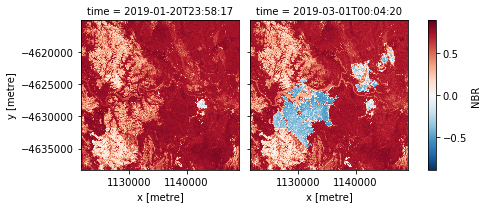

In [13]:
# Plot the two timesteps side-by-side
dc_NBR.NBR.plot(col="time")

In [14]:
# Subtract pre - post
dNBR = dc_NBR.isel(time=0) - dc_NBR.isel(time=1)
# Re-attach crs attribute
dNBR.attrs['crs'] = dc_NBR.crs
dNBR

<xarray.Dataset>
Dimensions:  (x: 919, y: 772)
Coordinates:
  * y        (y) float64 -4.615e+06 -4.615e+06 ... -4.638e+06 -4.638e+06
  * x        (x) float64 1.122e+06 1.122e+06 1.122e+06 ... 1.149e+06 1.149e+06
Data variables:
    NBR      (y, x) float64 0.02075 0.02891 0.02986 ... 0.01701 0.009292
Attributes:
    crs:      EPSG:3577

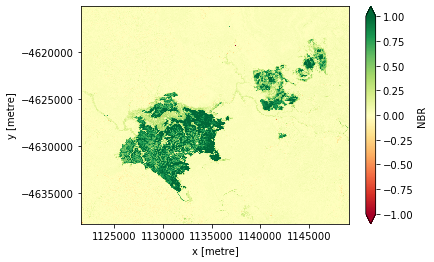

In [15]:
#Plot the delta NBR image
#dNBR
dNBR.NBR.plot(vmin=-1, vmax=1, cmap='RdYlGn')

In [22]:
'''
#**Alternate difference mthod, but will do postNBR - preNBR based on time dimension**
#Calculate the difference between the two indexes
dNBR = dc_NBR.diff('time') # Is this the right way around?
dNBR

#Plot the delta NBR image
#dNBR
dNBR.NBR.isel(time=0).plot(vmin=-1, vmax=1, cmap='RdYlGn')
'''

"\n#**Alternate difference mthod, but will do post - pre based on time**\n#Calculate the difference between the two indexes\ndNBR = dc_NBR.diff('time') # Is this the right way around?\ndNBR\n"

In [36]:
# Export the dNBR image to a geotiff
write_geotiff(outputdir + 'dNBR_tif', dNBR[['NBR']])

#Option to export pre and post fire images also
for i in range(len(dc_comb.time)):

    # We will use the date of the satellite image to name the GeoTIFF
    date = str(dc_comb.isel(time=i).time.data)[:-19]
    print(f'Writing {date}')

    # Write GeoTIFF
    write_geotiff(outputdir + f'{date}.tif', dc_comb.isel(time=i))

Writing 2019-01-20
Writing 2019-03-01
